__BoW, классификатор изображений__

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

## загружаем датасет

UIUC Image Database for Car Detection   
https://cogcomp.seas.upenn.edu/Data/Car/

https://disk.yandex.ru/d/KEZSpmlzTekTgw

In [2]:
from skimage.io import imread

folder_train = 'cars/train'

# позитивные примеры
with open(folder_train+'/pos/index.txt','rt') as f: files = f.read()
im_pos = np.stack([ imread(folder_train+'/pos/'+f) for f in files.split('\n') if f ])

# негативные примеры
with open(folder_train+'/neg/index.txt','rt') as f: files = f.read()
im_neg = np.stack([ imread(folder_train+'/neg/'+f) for f in files.split('\n') if f ])

del files

In [3]:
im_pos.shape, im_neg.shape

((550, 40, 100), (500, 40, 100))

In [4]:
data = np.vstack([im_pos,im_neg])
target = np.array( [1]*len(im_pos) + [0]*len(im_neg) )
data.shape, target.shape

((1050, 40, 100), (1050,))

In [5]:
del im_pos
del im_neg

### делим датасет на учебный и тестовый

In [6]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(data,target, test_size=.33,)

( data_train.shape, target_train.shape ), ( data_test.shape, target_test.shape )

(((703, 40, 100), (703,)), ((347, 40, 100), (347,)))

In [7]:
del data
del target

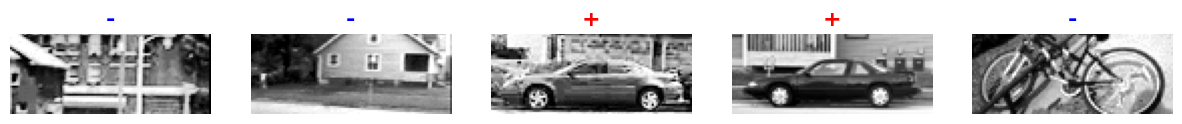

In [8]:
n_show = 5
# учебные примеры
plt.figure(figsize=(15,3))
ii = rng.permutation( len(data_train) )[:n_show]
for n,i in enumerate(ii,start=1 ):
    plt.subplot(2,n_show,n)
    plt.axis(False)
    t = '+' if target_train[i]>0 else '-'
    c = 'r' if target_train[i]>0 else 'b'
    plt.title(t,color=c,fontdict = {'fontsize':16,'fontweight':'bold'})  
    plt.imshow(data_train[i],cmap='gray')

## строим визуальный словарь

In [9]:
# from skimage.feature import ORB
# descriptor_extractor = ORB(n_keypoints=100)

from skimage.feature import SIFT
descriptor_extractor = SIFT()

# детектим особые точки и строим на них дескрипторы
def extract_descriptors( im, descriptor_extractor=descriptor_extractor ):
    try:
        descriptor_extractor.detect_and_extract(im)
        d = descriptor_extractor.descriptors
        if len(d)<1:
            print('WARNING: no descriptors found')
            d=None
            
    except Exception as e:
        print('WARNING:',e)
        d = None
    return d

In [10]:
# извлекаем список дескрипторов ("визуальных" символов) из учебных примеров
descriptors = np.vstack([ 
    d for d in 
    [ extract_descriptors(im) for im in tqdm(data_train) ] 
    if not (d is None) 
])

descriptors.shape

  0%|          | 0/703 [00:00<?, ?it/s]

(42619, 128)

In [11]:
%%time 

# строим каталог "визуальных" слов -
# кластеризируем список дескрипторов ("визуальных" символов), 
# которые извлекли из учебных примеров

from sklearn.cluster import KMeans

n_clusters = 128 # количество кластеров

descriptors_labels = KMeans(n_clusters=n_clusters).fit(descriptors).labels_

/opt/venv/jupyter_1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CPU times: user 1min 53s, sys: 3.53 s, total: 1min 57s
Wall time: 1min


(array([4280., 4380., 4173., 4390., 4437., 4471., 3864., 4103., 4319.,
        4202.]),
 array([  0. ,  12.7,  25.4,  38.1,  50.8,  63.5,  76.2,  88.9, 101.6,
        114.3, 127. ]),
 <BarContainer object of 10 artists>)

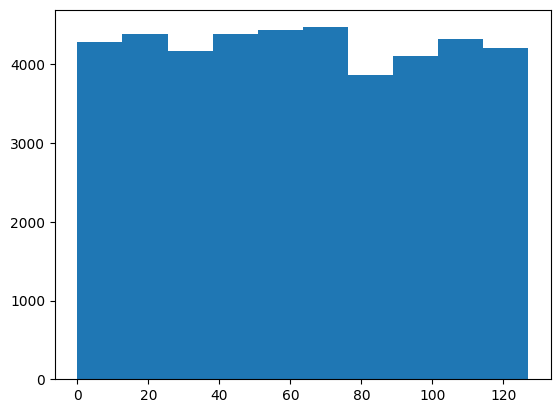

In [12]:
# распределение дескрипторов по кластерам
plt.hist( descriptors_labels )

## извлекаем признаки из картинок

In [13]:
from skimage.feature import match_descriptors

def extract_features(
    im, # картинка для обработки 
    descriptor_extractor=descriptor_extractor, # извлекатор дескрипторов
    # каталог "визуальных" слов (словарь)
    descriptors=descriptors, # список дескрипторов для сравнения ("визуальные" символы)
    descriptors_labels=descriptors_labels, # метки кластров для "визуальных" символов ("визуальные" слова)
):
    # извлекаем дескрипторы из картинки
    ds = extract_descriptors(im,descriptor_extractor=descriptor_extractor,)
    if ds is None: return None 
    
    # ищем соответвия со списком дескрипторов извлечённым из учебных примеров
    matches = match_descriptors(ds, descriptors)
    if len(matches)<1: return None  
    
    # считаем склолько дескрипторов совпали и в какой кластер они попали 
    labels = descriptors_labels[ matches[:,1] ]
    return np.eye(n_clusters,dtype=np.uint16)[labels].sum(axis=0,dtype=np.uint16)

# на выходе имеем вектор частотной характеристики,
# т.е. сколько дескрипторов из картинки попало в каждый кластер 

### собираем учебный датасет

In [14]:
%%time 

# частотные характеристики примеров учебного набора
X_train = [ extract_features(im) for im in tqdm(data_train) ]    
print( len(X_train) )

# выкидываем примеры, из которых не удалось извлечь признаки (не найдены особые точки и их дескрипторы)
ii = [ i for i,x in enumerate(X_train) if not (x is None)  ]
X_train = np.array([ X_train[i] for i in ii ])
y_train = target_train[ii]

X_train.shape, y_train.shape # размер учебного датасета

  0%|          | 0/703 [00:00<?, ?it/s]

703
CPU times: user 3min 29s, sys: 2.13 s, total: 3min 32s
Wall time: 4min 31s


((702, 128), (702,))

## обучаем модель

In [15]:
%%time

from sklearn import svm

model = svm.SVC().fit(X_train, y_train)

CPU times: user 20.5 ms, sys: 0 ns, total: 20.5 ms
Wall time: 22.9 ms


## тестируем модель

### результаты на учебном датасете

In [16]:
from sklearn.metrics import classification_report

In [17]:
o = model.predict(X_train)

print(classification_report(y_train, o) )

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       338
           1       1.00      0.99      0.99       364

    accuracy                           0.99       702
   macro avg       0.99      0.99      0.99       702
weighted avg       0.99      0.99      0.99       702



### результаты на тестовом датасете

In [18]:
%%time 

# частотные характеристики примеров учебного набора
X_test = [ extract_features(im) for im in tqdm(data_test) ]    
print( len(X_test) )

# выкидываем примеры, из которых не удалось извлечь признаки (не найдены особые точки и их дескрипторы)
ii = [ i for i,x in enumerate(X_test) if not (x is None)  ]
X_test = np.array([ X_test[i] for i in ii ])
y_test = target_test[ii]

X_test.shape, y_test.shape # размер учебного датасета

  0%|          | 0/347 [00:00<?, ?it/s]

347
CPU times: user 1min 43s, sys: 842 ms, total: 1min 44s
Wall time: 2min 17s


((347, 128), (347,))

In [19]:
o = model.predict(X_test)

print(classification_report(y_test, o) )

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       161
           1       0.90      0.91      0.91       186

    accuracy                           0.90       347
   macro avg       0.90      0.90      0.90       347
weighted avg       0.90      0.90      0.90       347

